Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


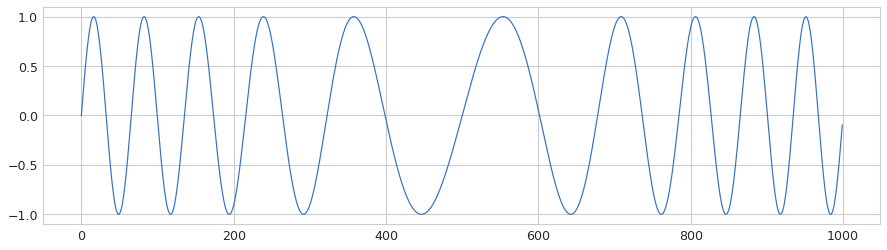

M=10000
Signal Length M=10000


In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:1'

fs = 100000 # sampling frequency, Hz
fc = 1000  # carrier frequency, Hz
fm = 100   # modulation frequency, Hz
T = 1. # seconds
twopi = 2*np.pi
t = np.linspace(0, T, int(T*fs), endpoint=False) # time variable
# Produce ramp from 0 to 1
beta = np.linspace(0, 6., int(T*fs)) # increase by two's for slower
signal = np.sin(twopi*fc*t + beta*np.sin(twopi*fm*t))[-10000:]
FREERUN  = 0
plt.figure(figsize=(15,4))
plt.plot(signal[:1000])
plt.show()

M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 500
REG = 1e-8
TRAINLENGTH = M-TEST
print(f'M={M}')
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
print(f'Signal Length M={M}')

In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
min_a, max_a = .2, .3
min_sr, max_sr = .35, .55
min_g, max_g = .2, 1.8
min_ri, max_ri = .001, 5.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .3)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        #ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./S4_Saved_Models/S4_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./S4_Saved_Models/S4_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./S4_Saved_Models/S4_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./S4_Saved_Models/S4_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)  
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss


 ********** size1000 ref0 run 0 ***********
Iter: 0 #### Diagnostic 1000.000   Time 12.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 7.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 5.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.00  Best 1000.000 NRMSE 2990064231535800320.000 CD 1.000
Iter: 11 #### Diagnostic 1000.000 

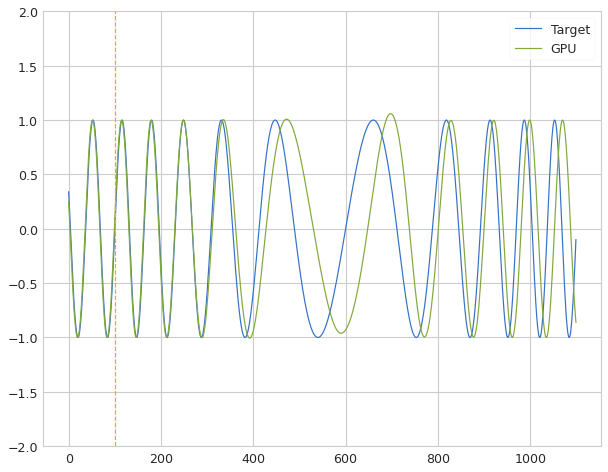

 Iter=44 a=0.290 sr=0.498 amp=1.430  ri=1.624 rr=0.797 loss=0.297191


Iter: 44 #### Diagnostic 0.297   Time 5.85  Best 0.297 NRMSE 0.297 CD 0.354
Iter: 45 #### Diagnostic 0.522   Time 6.15  Best 0.297 NRMSE 0.522 CD 1.096
Iter: 46 #### Diagnostic 1000.000   Time 5.84  Best 0.297 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 5.49  Best 0.297 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 6.20  Best 0.297 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 5.89  Best 0.297 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 6.05  Best 0.297 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 6.17  Best 0.297 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 7.15  Best 0.297 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.391   Time 7.21  Best 0.297 NRMSE 0.391 CD 0.612
Iter: 54 #### Diagnostic 1000.000   Time 6.28  Best 0.297 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 5.91  Best 0.297 NRM

Iter: 42 #### Diagnostic 1000.000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 6.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 6.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.536   Time 5.49  Best 1000.000 NRMSE 0.536 CD 1.169
Iter: 47 #### Diagnostic 1000.000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 8.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 8.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.431   Time 7.28  Best 1000.000 NRMSE 0.431 CD 0.746
Iter: 54 ###

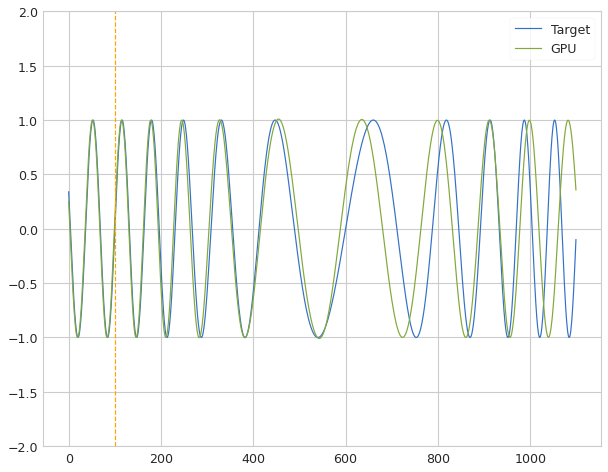

 Iter=24 a=0.228 sr=0.400 amp=1.636  ri=4.176 rr=0.732 loss=0.264616


Iter: 24 #### Diagnostic 0.265   Time 14.31  Best 0.265 NRMSE 0.265 CD 0.279
Iter: 25 #### Diagnostic 1000.000   Time 14.64  Best 0.265 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.347   Time 14.67  Best 0.265 NRMSE 0.347 CD 0.479
Iter: 27 #### Diagnostic 1000.000   Time 16.73  Best 0.265 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 17.13  Best 0.265 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 15.77  Best 0.265 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 18.66  Best 0.265 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 14.81  Best 0.265 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 13.93  Best 0.265 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.378   Time 15.70  Best 0.265 NRMSE 0.378 CD 0.578
Iter: 34 #### Diagnostic 1000.000   Time 15.99  Best 0.265 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.492   Time 17.71  Best 

Iter: 23 #### Diagnostic 1000.000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.509   Time 7.82  Best 1000.000 NRMSE 0.509 CD 1.041
Iter: 25 #### Diagnostic 1000.000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.452   Time 5.94  Best 1000.000 NRMSE 0.452 CD 0.821
Iter: 33 #### Diagnostic 1000.000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 ###

Iter: 20 #### Diagnostic 0.316   Time 6.32  Best 1000.000 NRMSE 0.316 CD 0.406
Iter: 21 #### Diagnostic 0.439   Time 7.30  Best 1000.000 NRMSE 0.439 CD 0.771
Iter: 22 #### Diagnostic 0.415   Time 8.08  Best 1000.000 NRMSE 0.415 CD 0.694
Iter: 23 #### Diagnostic 1000.000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 6.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 0.347   Time 7.01  Best 1000.000 NRMSE 0.347 CD 0.484
Iter: 28 #### Diagnostic 1000.000   Time 8.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.428   Time 7.04  Best 1000.000 NRMSE 0.428 CD 0.735
Iter: 30 #### Diagnostic 1000.000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.386   Time 5.91  Best 1000.000 NRMSE 0.386 CD 0.598
Iter: 32 #### Diagnostic 100

Iter: 10 #### Diagnostic 1000.000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 6.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 6.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 8 #### Diagnostic 1000.000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.497   Time 5.82  Best 1000.000 NRMSE 0.497 CD 0.994
Iter: 11 #### Diagnostic 0.477   Time 6.79  Best 1000.000 NRMSE 0.477 CD 0.911
Iter: 12 #### Diagnostic 0.603   Time 6.96  Best 1000.000 NRMSE 0.603 CD 1.022
Iter: 13 #### Diagnostic 1000.000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 6.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 10.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 6.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Dia

Iter: 6 #### Diagnostic 0.580   Time 6.21  Best 1000.000 NRMSE 0.580 CD 1.347
Iter: 7 #### Diagnostic 1000.000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.447   Time 5.64  Best 1000.000 NRMSE 0.447 CD 0.802
Iter: 10 #### Diagnostic 1000.000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.531   Time 5.77  Best 1000.000 NRMSE 0.531 CD 1.134
Iter: 12 #### Diagnostic 1000.000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagno

Iter: 4 #### Diagnostic 0.399   Time 6.84  Best 1000.000 NRMSE 0.399 CD 0.644
Iter: 5 #### Diagnostic 1000.000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 6.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 6.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.414   Time 5.37  Best 1000.000 NRMSE 0.414 CD 0.692
Iter: 12 #### Diagnostic 1000.000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 6.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.395   Time 6.92  Best 1000.000 NRMSE 0.395 CD 0.623
Iter: 15 #### Diagnostic 1000.000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnost

Iter: 2 #### Diagnostic 1000.000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 6.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 8.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 5.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 ###

Iter: 0 #### Diagnostic 1000.000   Time 6.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 6.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.448   Time 5.73  Best 1000.000 NRMSE 0.448 CD 0.803
Iter: 4 #### Diagnostic 1000.000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.463   Time 7.00  Best 1000.000 NRMSE 0.463 CD 0.860
Iter: 10 #### Diagnostic 1000.000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 5.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnost


Best result = 0.3450363883544395
a = 0.29939140183033547
sr = 0.470522879432819
amp = 0.20358855077389892
ri = 0.15527483303845258
rr = 3.322787190165968

 ********** size1000 ref2 run 1 ***********
Iter: 0 #### Diagnostic 1000.000   Time 6.20  Best 1000.000 NRMSE 18514024210456059840524376342528.000 CD 1.000
Iter: 1 #### Diagnostic 1000.000   Time 6.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 5.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.441   Time 6.04  Best 1000.000 NRMSE 0.441 CD 0.776
Iter: 5 #### Diagnostic 0.456   Time 6.51  Best 1000.000 NRMSE 0.456 CD 0.834
Iter: 6 #### Diagnostic 0.413   Time 5.67  Best 1000.000 NRMSE 0.413 CD 0.678
Iter: 7 #### Diagnostic 1000.000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.351   Time 5.97  B

Iter: 97 #### Diagnostic 0.568   Time 5.31  Best 1000.000 NRMSE 0.568 CD 1.331
Iter: 98 #### Diagnostic 1000.000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.35072111208821005
a = 0.258298883402403
sr = 0.5355393878593985
amp = 1.088878020094641
ri = 3.4226284616333844
rr = 0.9419900295497974

 ********** size1000 ref2 run 2 ***********
Iter: 0 #### Diagnostic 1000.000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 6.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 6.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 6.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 6.28  Best 1000.000 NRMSE

Iter: 93 #### Diagnostic 1000.000   Time 11.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 11.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 0.402   Time 12.18  Best 1000.000 NRMSE 0.402 CD 0.643
Iter: 96 #### Diagnostic 1000.000   Time 10.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 10.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 0.371   Time 11.71  Best 1000.000 NRMSE 0.371 CD 0.554
Iter: 99 #### Diagnostic 1000.000   Time 14.29  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.31166945338796637
a = 0.2649573254731169
sr = 0.4119923276859701
amp = 1.546166028424981
ri = 2.4838281116392
rr = 3.5189947663174763

 ********** size1000 ref2 run 3 ***********
Iter: 0 #### Diagnostic 1000.000   Time 11.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 12.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 13.15  Best 1000.0

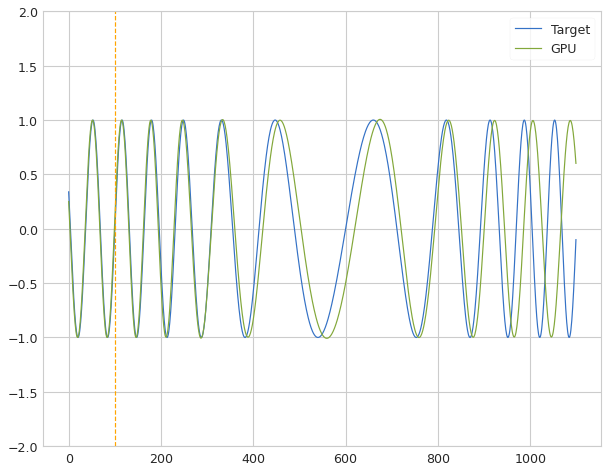

 Iter=33 a=0.272 sr=0.376 amp=1.779  ri=1.484 rr=1.165 loss=0.262977


Iter: 33 #### Diagnostic 0.263   Time 14.31  Best 0.263 NRMSE 0.263 CD 0.276
Iter: 34 #### Diagnostic 1000.000   Time 9.49  Best 0.263 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 11.62  Best 0.263 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 10.67  Best 0.263 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 13.30  Best 0.263 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 12.88  Best 0.263 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 15.83  Best 0.263 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 12.10  Best 0.263 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 13.72  Best 0.263 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 13.51  Best 0.263 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 12.05  Best 0.263 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 13

Iter: 31 #### Diagnostic 1000.000   Time 11.61  Best 1000.000 NRMSE 17438513149888945597274128384.000 CD 1.000
Iter: 32 #### Diagnostic 1000.000   Time 12.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 14.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 10.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 12.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 11.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 12.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 10.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 11.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 0.541   Time 11.12  Best 1000.000 NRMSE 0.541 CD 1.169
Iter: 41 #### Diagnostic 0.453   Time 10.77  Best 1000.000 NRMSE 0.453 CD 0.821
Iter: 42 #### Diagnostic 1000.000   Time 13.89  Best 1000

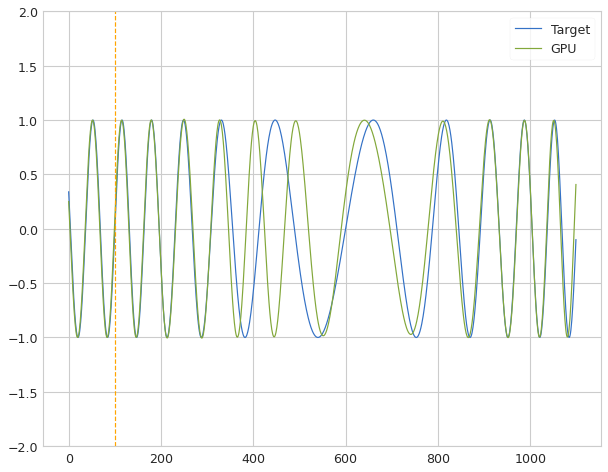

 Iter=9 a=0.292 sr=0.486 amp=1.781  ri=2.349 rr=4.118 loss=0.250329


Iter: 9 #### Diagnostic 0.250   Time 16.94  Best 0.250 NRMSE 0.250 CD 0.252
Iter: 10 #### Diagnostic 1000.000   Time 10.20  Best 0.250 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 14.19  Best 0.250 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 11.62  Best 0.250 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 12.40  Best 0.250 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 12.65  Best 0.250 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 11.72  Best 0.250 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 11.89  Best 0.250 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 13.63  Best 0.250 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 11.43  Best 0.250 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 13.00  Best 0.250 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 15.

Iter: 8 #### Diagnostic 0.378   Time 12.15  Best 1000.000 NRMSE 0.378 CD 0.570
Iter: 9 #### Diagnostic 0.578   Time 12.85  Best 1000.000 NRMSE 0.578 CD 1.334
Iter: 10 #### Diagnostic 1000.000   Time 13.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 13.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.571   Time 11.95  Best 1000.000 NRMSE 0.571 CD 0.999
Iter: 13 #### Diagnostic 1000.000   Time 9.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 12.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 11.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 11.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 11.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.370   Time 12.28  Best 1000.000 NRMSE 0.370 CD 0.547
Iter: 19 #### Diagnostic 1000.000   Time 12.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 ##

Iter: 5 #### Diagnostic 1000.000   Time 13.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 11.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 11.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 13.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 14.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 13.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.449   Time 14.52  Best 1000.000 NRMSE 0.449 CD 0.807
Iter: 12 #### Diagnostic 1000.000   Time 14.49  Best 1000.000 NRMSE 15478230535170137479290485261467648.000 CD 1.000
Iter: 13 #### Diagnostic 1000.000   Time 13.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 13.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 13.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 11.57  Best

Iter: 1 #### Diagnostic 1000.000   Time 14.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 0.470   Time 12.27  Best 1000.000 NRMSE 0.470 CD 0.878
Iter: 3 #### Diagnostic 0.384   Time 14.34  Best 1000.000 NRMSE 0.384 CD 0.590
Iter: 4 #### Diagnostic 1000.000   Time 12.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 11.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 10.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 9.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 11.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 12.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 12.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 12.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 11.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #


Best result = 0.3014836904793492
a = 0.27661855668597923
sr = 0.5216184942834241
amp = 1.5003089910207845
ri = 3.2159325698520247
rr = 3.0715178566614627

 ********** size1000 ref3 run 4 ***********
Iter: 0 #### Diagnostic 0.534   Time 9.10  Best 1000.000 NRMSE 0.534 CD 1.142
Iter: 1 #### Diagnostic 1000.000   Time 10.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 12.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 13.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.316   Time 12.35  Best 1000.000 NRMSE 0.316 CD 0.403
Iter: 5 #### Diagnostic 1000.000   Time 10.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.365   Time 11.92  Best 1000.000 NRMSE 0.365 CD 0.533
Iter: 7 #### Diagnostic 1000.000   Time 12.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 13.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 12.16  Best 1000.000 NRMSE

Iter: 97 #### Diagnostic 1000.000   Time 12.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 14.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 14.31  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.31598179026626383
a = 0.21495289982998864
sr = 0.37741784214286717
amp = 1.239365387835551
ri = 3.817622359161981
rr = 4.082402009201102

Best mn:0.292	 mn:0.292
New bounds mn--mx: 0.051--0.032

Best mn:0.486	 mn:0.486
New bounds mn--mx: 0.102--0.048

Best mn:1.781	 mn:1.781
New bounds mn--mx: 0.344--0.199

Best mn:2.349	 mn:2.349
New bounds mn--mx: 0.702--0.917

Best mn:4.118	 mn:4.118
New bounds mn--mx: 1.722---0.681
Refined search bounds:

Alpha (0.24096050688999932, 0.3248005361548092)

Rho (0.38366825678433497, 0.5332569398504556)

Gamma (1.4373315852455772, 1.9797717895340703)

r-in (1.6469148461811791, 3.265929367040341)

r-res (2.396126338881608, 3.437239574256734)

End Refinement Run 3 Time 6046.986

 ********** 

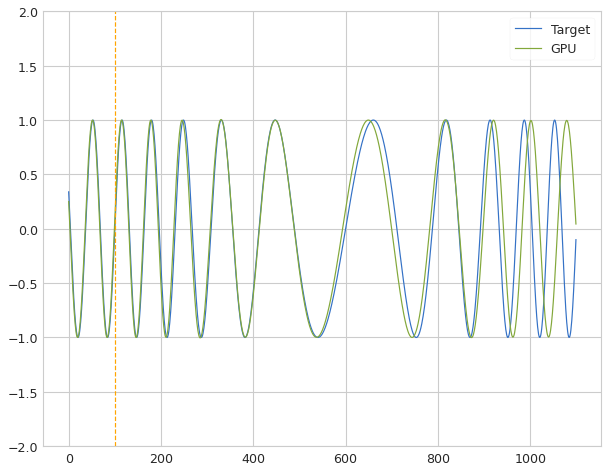

 Iter=38 a=0.261 sr=0.385 amp=1.673  ri=1.706 rr=1.015 loss=0.220143


Iter: 38 #### Diagnostic 0.220   Time 9.99  Best 0.220 NRMSE 0.220 CD 0.194
Iter: 39 #### Diagnostic 1000.000   Time 12.58  Best 0.220 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 14.34  Best 0.220 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 0.387   Time 10.46  Best 0.220 NRMSE 0.387 CD 0.600
Iter: 42 #### Diagnostic 1000.000   Time 12.55  Best 0.220 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 12.09  Best 0.220 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 0.353   Time 11.61  Best 0.220 NRMSE 0.353 CD 0.500
Iter: 45 #### Diagnostic 0.422   Time 12.61  Best 0.220 NRMSE 0.422 CD 0.716
Iter: 46 #### Diagnostic 1000.000   Time 12.27  Best 0.220 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.337   Time 10.95  Best 0.220 NRMSE 0.337 CD 0.452
Iter: 48 #### Diagnostic 1000.000   Time 12.31  Best 0.220 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 11.26  Best 0.220 

Iter: 37 #### Diagnostic 0.358   Time 11.57  Best 1000.000 NRMSE 0.358 CD 0.512
Iter: 38 #### Diagnostic 1000.000   Time 11.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 11.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 14.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 0.463   Time 13.16  Best 1000.000 NRMSE 0.463 CD 0.852
Iter: 42 #### Diagnostic 0.494   Time 12.54  Best 1000.000 NRMSE 0.494 CD 0.973
Iter: 43 #### Diagnostic 1000.000   Time 13.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 12.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 11.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.466   Time 12.39  Best 1000.000 NRMSE 0.466 CD 0.881
Iter: 47 #### Diagnostic 1000.000   Time 13.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 11.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49

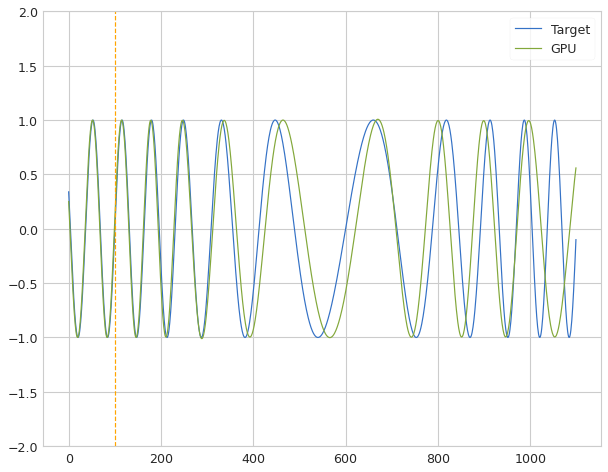

 Iter=13 a=0.214 sr=0.410 amp=1.491  ri=1.598 rr=0.107 loss=0.266715


Iter: 13 #### Diagnostic 0.267   Time 12.93  Best 0.267 NRMSE 0.267 CD 0.286
Iter: 14 #### Diagnostic 1000.000   Time 12.05  Best 0.267 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 9.18  Best 0.267 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 12.82  Best 0.267 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 12.09  Best 0.267 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 10.30  Best 0.267 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 13.10  Best 0.267 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 14.91  Best 0.267 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 12.07  Best 0.267 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 13.97  Best 0.267 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 11.35  Best 0.267 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 14

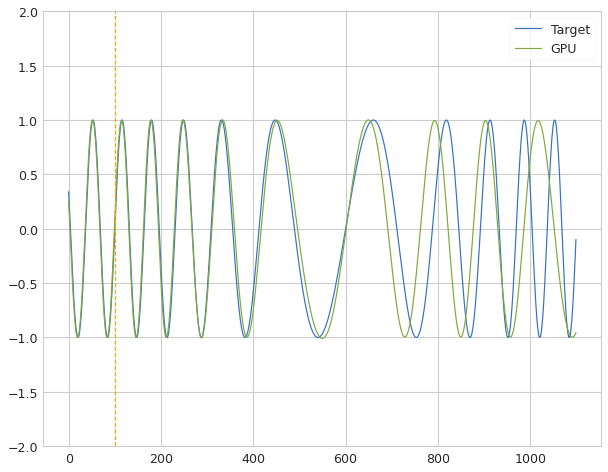

 Iter=42 a=0.240 sr=0.508 amp=1.188  ri=2.958 rr=0.624 loss=0.260870


Iter: 42 #### Diagnostic 0.261   Time 12.75  Best 0.261 NRMSE 0.261 CD 0.271
Iter: 43 #### Diagnostic 1000.000   Time 11.23  Best 0.261 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 11.35  Best 0.261 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 11.22  Best 0.261 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.293   Time 9.33  Best 0.261 NRMSE 0.293 CD 0.343
Iter: 47 #### Diagnostic 1000.000   Time 11.21  Best 0.261 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 15.51  Best 0.261 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 12.00  Best 0.261 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 13.41  Best 0.261 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 10.74  Best 0.261 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 10.86  Best 0.261 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 14.50 

Iter: 40 #### Diagnostic 1000.000   Time 11.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 0.443   Time 11.30  Best 1000.000 NRMSE 0.443 CD 0.791
Iter: 42 #### Diagnostic 1000.000   Time 11.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 13.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 10.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 13.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 11.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 14.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 13.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 12.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 11.57  Best 1000.000 NRMSE 1000.000 CD n

Iter: 36 #### Diagnostic 0.420   Time 11.52  Best 1000.000 NRMSE 0.420 CD 0.702
Iter: 37 #### Diagnostic 1000.000   Time 13.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 11.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 13.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 10.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 9.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 0.465   Time 12.73  Best 1000.000 NRMSE 0.465 CD 0.864
Iter: 43 #### Diagnostic 1000.000   Time 11.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 13.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 11.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 11.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 13.83  Best 1000.000 NRMSE 1000.000 CD nan
I

Iter: 25 #### Diagnostic 1000.000   Time 9.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 10.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 10.24  Best 1000.000 NRMSE 2459280869644494906064896.000 CD 1.000
Iter: 28 #### Diagnostic 1000.000   Time 11.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 10.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 12.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 9.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.452   Time 11.31  Best 1000.000 NRMSE 0.452 CD 0.842
Iter: 33 #### Diagnostic 1000.000   Time 9.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 10.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.513   Time 8.59  Best 1000.000 NRMSE 0.513 CD 1.052
Iter: 36 #### Diagnostic 1000.000   Time 10.90  Best 1000.000 NRM

Iter: 22 #### Diagnostic 1000.000   Time 9.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 0.486   Time 9.73  Best 1000.000 NRMSE 0.486 CD 0.947
Iter: 24 #### Diagnostic 1000.000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.470   Time 10.24  Best 1000.000 NRMSE 0.470 CD 0.884
Iter: 26 #### Diagnostic 1000.000   Time 10.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 10.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 13.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 11.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 10.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 11.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.540   Time 11.30  Best 1000.000 NRMSE 0.540 CD 1.148
Iter: 34

Iter: 19 #### Diagnostic 0.434   Time 11.71  Best 1000.000 NRMSE 0.434 CD 0.756
Iter: 20 #### Diagnostic 1000.000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 8.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 9.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 10.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 11.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.437   Time 10.51  Best 1000.000 NRMSE 0.437 CD 0.743
Iter: 26 #### Diagnostic 1000.000   Time 10.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 10.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 11.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 10.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 15 #### Diagnostic 1000.000   Time 8.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 10.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 11.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 11.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 11.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 10.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 8.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 9.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 8.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 9.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 10.76  Best 1000.000 NRMSE 1000.000 CD na

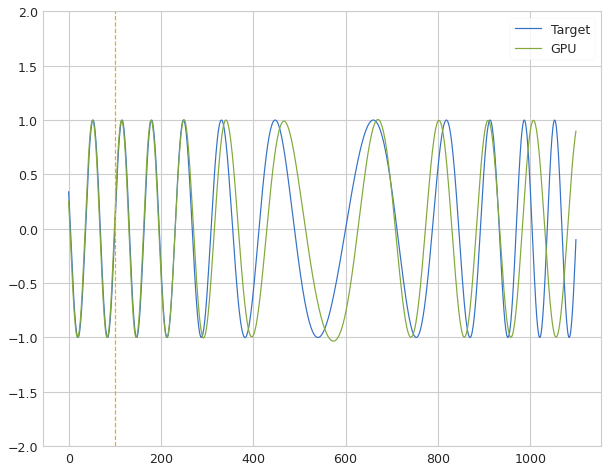

 Iter=83 a=0.272 sr=0.412 amp=1.671  ri=2.612 rr=2.387 loss=0.286199


Iter: 83 #### Diagnostic 0.286   Time 11.46  Best 0.286 NRMSE 0.286 CD 0.327
Iter: 84 #### Diagnostic 1000.000   Time 9.14  Best 0.286 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 8.93  Best 0.286 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 11.25  Best 0.286 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 9.89  Best 0.286 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 12.05  Best 0.286 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 12.70  Best 0.286 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 12.47  Best 0.286 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.663   Time 9.92  Best 0.286 NRMSE 0.663 CD 1.100
Iter: 92 #### Diagnostic 0.500   Time 11.75  Best 0.286 NRMSE 0.500 CD 0.983
Iter: 93 #### Diagnostic 1000.000   Time 10.30  Best 0.286 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 9.67  Best 0.

Iter: 80 #### Diagnostic 0.435   Time 8.58  Best 1000.000 NRMSE 0.435 CD 0.764
Iter: 81 #### Diagnostic 0.532   Time 12.77  Best 1000.000 NRMSE 0.532 CD 1.138
Iter: 82 #### Diagnostic 1000.000   Time 12.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 8.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 10.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 11.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 10.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 0.411   Time 9.60  Best 1000.000 NRMSE 0.411 CD 0.680
Iter: 88 #### Diagnostic 0.520   Time 8.95  Best 1000.000 NRMSE 0.520 CD 1.086
Iter: 89 #### Diagnostic 1000.000   Time 8.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 10.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### 

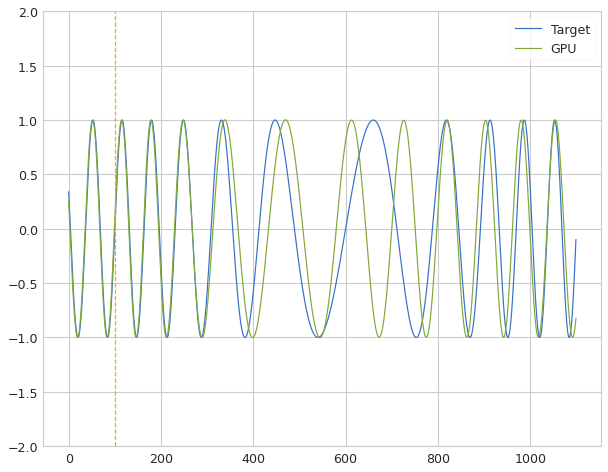

 Iter=47 a=0.273 sr=0.400 amp=1.264  ri=2.550 rr=3.053 loss=0.294379


Iter: 47 #### Diagnostic 0.294   Time 10.92  Best 0.294 NRMSE 0.294 CD 0.346
Iter: 48 #### Diagnostic 1000.000   Time 10.40  Best 0.294 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 9.07  Best 0.294 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 0.485   Time 12.41  Best 0.294 NRMSE 0.485 CD 0.945
Iter: 51 #### Diagnostic 0.402   Time 11.05  Best 0.294 NRMSE 0.402 CD 0.649
Iter: 52 #### Diagnostic 0.447   Time 10.12  Best 0.294 NRMSE 0.447 CD 0.798
Iter: 53 #### Diagnostic 0.488   Time 11.39  Best 0.294 NRMSE 0.488 CD 0.959
Iter: 54 #### Diagnostic 1000.000   Time 11.47  Best 0.294 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 0.357   Time 11.30  Best 0.294 NRMSE 0.357 CD 0.814
Iter: 56 #### Diagnostic 1000.000   Time 9.62  Best 0.294 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 11.32  Best 0.294 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 0.415   Time 9.58  Best 0.294 NRMSE 0.4

Iter: 45 #### Diagnostic 1000.000   Time 10.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.443   Time 11.93  Best 1000.000 NRMSE 0.443 CD 0.805
Iter: 47 #### Diagnostic 1000.000   Time 13.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 8.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 12.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 9.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 9.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.468   Time 9.86  Best 1000.000 NRMSE 0.468 CD 0.877
Iter: 54 #### Diagnostic 1000.000   Time 11.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 9.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 10.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 

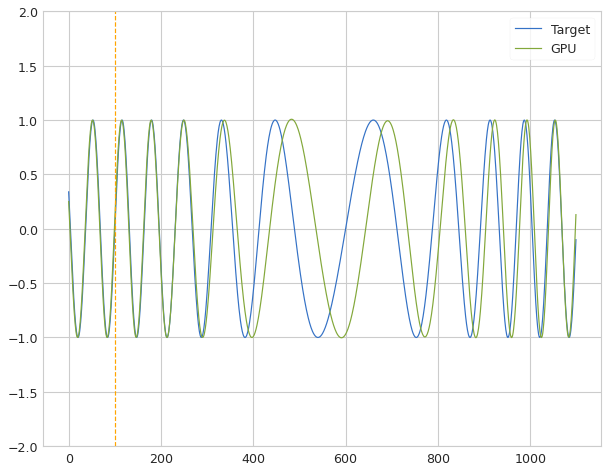

 Iter=30 a=0.265 sr=0.412 amp=1.546  ri=2.484 rr=3.519 loss=0.278143


Iter: 30 #### Diagnostic 0.278   Time 11.44  Best 0.278 NRMSE 0.278 CD 0.310
Iter: 31 #### Diagnostic 1000.000   Time 12.61  Best 0.278 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 10.10  Best 0.278 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 11.71  Best 0.278 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 12.01  Best 0.278 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.410   Time 11.35  Best 0.278 NRMSE 0.410 CD 0.678
Iter: 36 #### Diagnostic 1000.000   Time 10.26  Best 0.278 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 11.26  Best 0.278 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 9.69  Best 0.278 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 11.32  Best 0.278 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 10.63  Best 0.278 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 10.43 

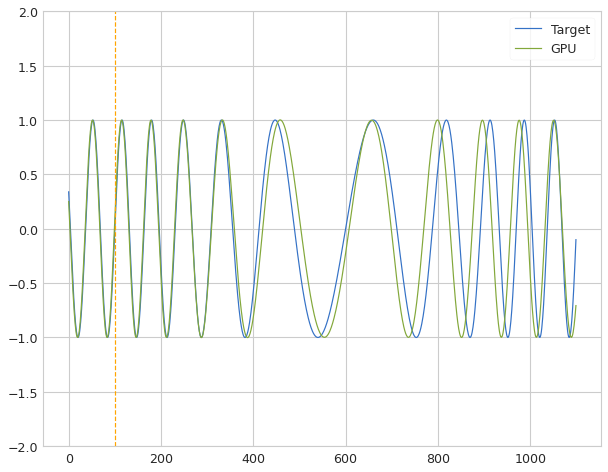

 Iter=17 a=0.228 sr=0.387 amp=1.629  ri=3.350 rr=0.865 loss=0.209907


Iter: 17 #### Diagnostic 0.210   Time 12.09  Best 0.210 NRMSE 0.210 CD 0.176
Iter: 18 #### Diagnostic 1000.000   Time 14.51  Best 0.210 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 10.02  Best 0.210 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 11.61  Best 0.210 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 11.75  Best 0.210 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 10.66  Best 0.210 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 9.90  Best 0.210 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.486   Time 12.43  Best 0.210 NRMSE 0.486 CD 0.945
Iter: 25 #### Diagnostic 1000.000   Time 12.39  Best 0.210 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.482   Time 10.12  Best 0.210 NRMSE 0.482 CD 0.926
Iter: 27 #### Diagnostic 1000.000   Time 10.98  Best 0.210 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 10.72  Bes

Iter: 16 #### Diagnostic 1000.000   Time 10.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 9.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.505   Time 12.48  Best 1000.000 NRMSE 0.505 CD 1.019
Iter: 19 #### Diagnostic 0.454   Time 10.37  Best 1000.000 NRMSE 0.454 CD 0.827
Iter: 20 #### Diagnostic 0.552   Time 10.22  Best 1000.000 NRMSE 0.552 CD 1.219
Iter: 21 #### Diagnostic 1000.000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.467   Time 8.54  Best 1000.000 NRMSE 0.467 CD 0.867
Iter: 23 #### Diagnostic 1000.000   Time 9.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.464   Time 12.16  Best 1000.000 NRMSE 0.464 CD 0.866
Iter: 25 #### Diagnostic 1000.000   Time 11.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 11.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 8.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Dia

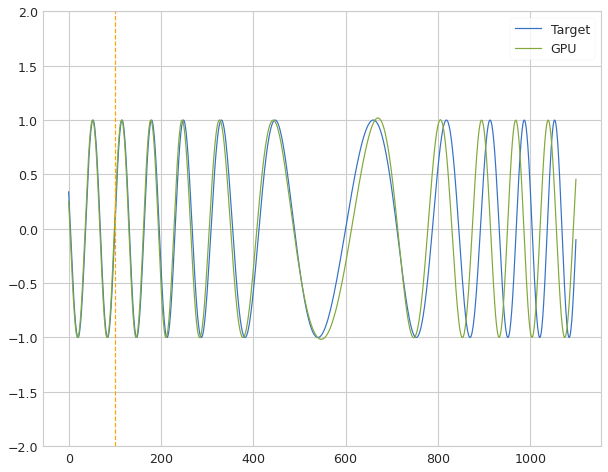

 Iter=61 a=0.272 sr=0.485 amp=1.400  ri=2.355 rr=0.660 loss=0.245674


Iter: 61 #### Diagnostic 0.246   Time 10.07  Best 0.246 NRMSE 0.246 CD 0.241
Iter: 62 #### Diagnostic 1000.000   Time 12.06  Best 0.246 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 10.25  Best 0.246 NRMSE 22046644.618 CD 0.990
Iter: 64 #### Diagnostic 1000.000   Time 9.37  Best 0.246 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 12.29  Best 0.246 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 0.446   Time 8.91  Best 0.246 NRMSE 0.446 CD 0.798
Iter: 67 #### Diagnostic 0.381   Time 12.83  Best 0.246 NRMSE 0.381 CD 0.579
Iter: 68 #### Diagnostic 0.531   Time 10.26  Best 0.246 NRMSE 0.531 CD 1.120
Iter: 69 #### Diagnostic 0.481   Time 12.18  Best 0.246 NRMSE 0.481 CD 0.925
Iter: 70 #### Diagnostic 0.487   Time 9.27  Best 0.246 NRMSE 0.487 CD 0.951
Iter: 71 #### Diagnostic 1000.000   Time 12.32  Best 0.246 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 9.17  Best 0.246 N

Iter: 52 #### Diagnostic 1000.000   Time 9.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 63.512   Time 8.20  Best 1000.000 NRMSE 63.512 CD 0.988
Iter: 54 #### Diagnostic 1000.000   Time 11.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 12.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 10.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 9.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 11.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.487   Time 10.58  Best 1000.000 NRMSE 0.487 CD 0.946
Iter: 61 #### Diagnostic 0.512   Time 11.58  Best 1000.000 NRMSE 0.512 CD 1.050
Iter: 62 #### Diagnostic 1000.000   Time 8.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 11.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6

Iter: 49 #### Diagnostic 1000.000   Time 12.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 11.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 0.513   Time 11.36  Best 1000.000 NRMSE 0.513 CD 1.048
Iter: 52 #### Diagnostic 1000.000   Time 9.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 10.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.450   Time 11.13  Best 1000.000 NRMSE 0.450 CD 0.809
Iter: 55 #### Diagnostic 0.363   Time 11.11  Best 1000.000 NRMSE 0.363 CD 0.524
Iter: 56 #### Diagnostic 1000.000   Time 10.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 0.506   Time 7.58  Best 1000.000 NRMSE 0.506 CD 0.953
Iter: 59 #### Diagnostic 1000.000   Time 10.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 9.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 ###

Iter: 45 #### Diagnostic 1000.000   Time 11.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 10.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 11.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 9.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 12.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 0.448   Time 12.11  Best 1000.000 NRMSE 0.448 CD 0.797
Iter: 52 #### Diagnostic 1000.000   Time 8.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 11.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.497   Time 8.90  Best 1000.000 NRMSE 0.497 CD 0.999
Iter: 55 #### Diagnostic 1000.000   Time 8.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 10.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter:

Iter: 41 #### Diagnostic 1000.000   Time 9.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 0.464   Time 12.03  Best 1000.000 NRMSE 0.464 CD 0.862
Iter: 43 #### Diagnostic 1000.000   Time 10.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 11.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 9.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 10.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.453   Time 11.26  Best 1000.000 NRMSE 0.453 CD 0.809
Iter: 48 #### Diagnostic 1000.000   Time 11.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 11.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 12.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 13.44  Best 1000.000 NRMSE 402237770682.133 CD 0.988
Iter: 52 #### Diagnostic 1000.000   Time 11.11  Best 1000.000 NRMSE 1000.000

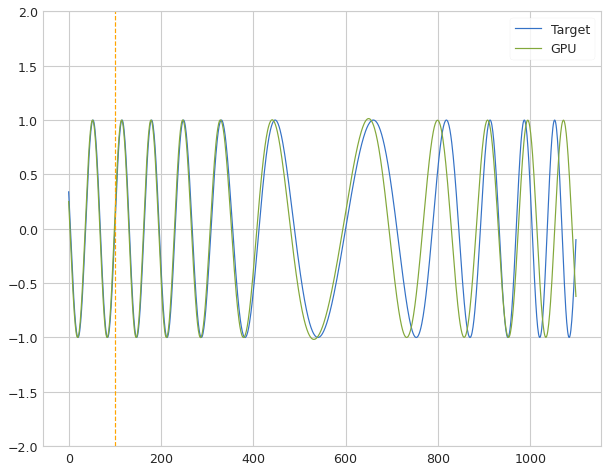

 Iter=75 a=0.270 sr=0.524 amp=1.258  ri=2.955 rr=0.649 loss=0.213829


Iter: 75 #### Diagnostic 0.214   Time 13.16  Best 0.214 NRMSE 0.214 CD 0.183
Iter: 76 #### Diagnostic 1000.000   Time 10.90  Best 0.214 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 9.91  Best 0.214 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 11.86  Best 0.214 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 9.04  Best 0.214 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 11.53  Best 0.214 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 11.32  Best 0.214 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 9.36  Best 0.214 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 0.441   Time 10.09  Best 0.214 NRMSE 0.441 CD 0.778
Iter: 84 #### Diagnostic 1000.000   Time 11.83  Best 0.214 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 11.63  Best 0.214 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 8.29  Be

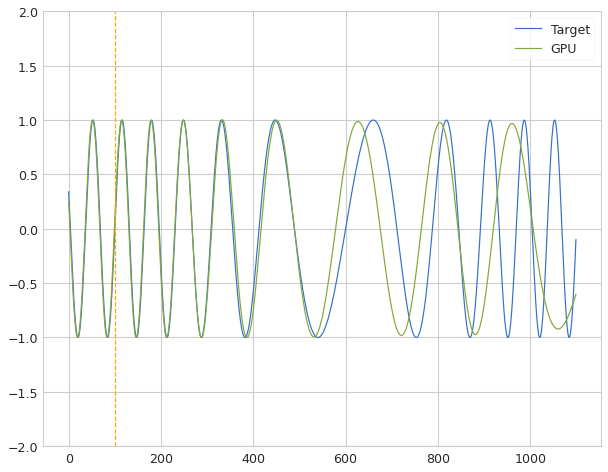

 Iter=57 a=0.221 sr=0.468 amp=1.630  ri=3.431 rr=0.800 loss=0.293886


Iter: 57 #### Diagnostic 0.294   Time 8.15  Best 0.294 NRMSE 0.294 CD 0.347
Iter: 58 #### Diagnostic 0.452   Time 8.34  Best 0.294 NRMSE 0.452 CD 0.817
Iter: 59 #### Diagnostic 1000.000   Time 11.02  Best 0.294 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 9.89  Best 0.294 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.418   Time 9.15  Best 0.294 NRMSE 0.418 CD 0.687
Iter: 62 #### Diagnostic 1000.000   Time 9.33  Best 0.294 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 0.362   Time 11.33  Best 0.294 NRMSE 0.362 CD 0.526
Iter: 64 #### Diagnostic 1000.000   Time 12.99  Best 0.294 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 12.21  Best 0.294 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 13.96  Best 0.294 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 11.44  Best 0.294 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.482   Time 9.86  Best 0.294 NRMS

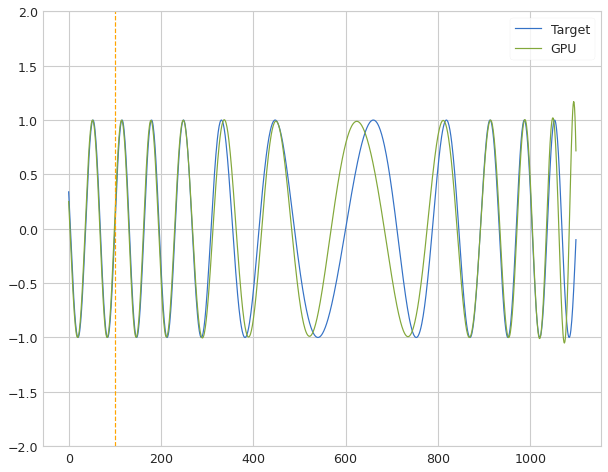

 Iter=44 a=0.290 sr=0.498 amp=1.430  ri=1.624 rr=0.797 loss=0.188571


Iter: 44 #### Diagnostic 0.189   Time 11.86  Best 0.189 NRMSE 0.189 CD 0.142
Iter: 45 #### Diagnostic 1000.000   Time 10.44  Best 0.189 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 13.19  Best 0.189 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 11.43  Best 0.189 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 10.52  Best 0.189 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 10.49  Best 0.189 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 8.20  Best 0.189 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 11.89  Best 0.189 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 0.402   Time 10.69  Best 0.189 NRMSE 0.402 CD 0.651
Iter: 53 #### Diagnostic 1000.000   Time 11.65  Best 0.189 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 9.01  Best 0.189 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 10.05  

Iter: 42 #### Diagnostic 0.440   Time 11.97  Best 1000.000 NRMSE 0.440 CD 0.781
Iter: 43 #### Diagnostic 0.468   Time 11.63  Best 1000.000 NRMSE 0.468 CD 0.877
Iter: 44 #### Diagnostic 1000.000   Time 9.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 8.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.375   Time 9.94  Best 1000.000 NRMSE 0.375 CD 0.565
Iter: 47 #### Diagnostic 1000.000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 9.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 11.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 10.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 10.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 9.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.506   Time 8.60  Best 1000.000 NRMSE 0.506 CD 1.026
Iter: 54 #### D

Iter: 39 #### Diagnostic 1000.000   Time 9.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 8.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 0.381   Time 11.52  Best 1000.000 NRMSE 0.381 CD 0.583
Iter: 43 #### Diagnostic 1000.000   Time 9.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 0.507   Time 11.84  Best 1000.000 NRMSE 0.507 CD 1.041
Iter: 45 #### Diagnostic 1000.000   Time 10.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 9.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.457   Time 13.08  Best 1000.000 NRMSE 0.457 CD 0.878
Iter: 48 #### Diagnostic 1000.000   Time 9.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 10.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 11.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #

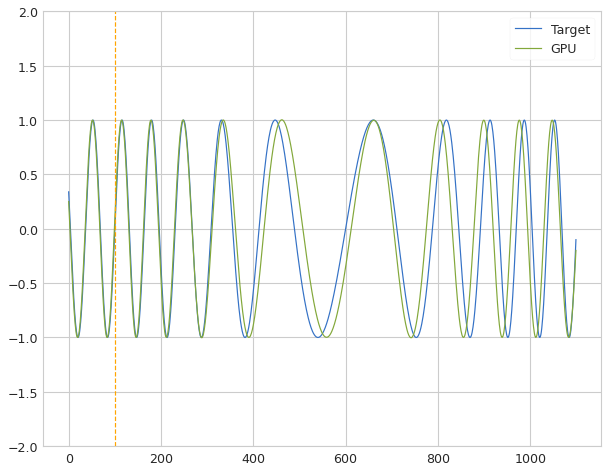

 Iter=11 a=0.244 sr=0.505 amp=1.207  ri=2.366 rr=2.728 loss=0.193479


Iter: 11 #### Diagnostic 0.193   Time 11.24  Best 0.193 NRMSE 0.193 CD 0.150
Iter: 12 #### Diagnostic 1000.000   Time 7.48  Best 0.193 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 10.11  Best 0.193 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 8.50  Best 0.193 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 9.63  Best 0.193 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 11.25  Best 0.193 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 9.05  Best 0.193 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 9.75  Best 0.193 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 9.39  Best 0.193 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 7.67  Best 0.193 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 11.78  Best 0.193 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 11.67  B

Iter: 11 #### Diagnostic 1000.000   Time 11.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 8.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 10.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.419   Time 9.12  Best 1000.000 NRMSE 0.419 CD 0.702
Iter: 15 #### Diagnostic 1000.000   Time 12.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 14.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.525   Time 10.09  Best 1000.000 NRMSE 0.525 CD 1.097
Iter: 18 #### Diagnostic 1000.000   Time 9.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 0.464   Time 8.92  Best 1000.000 NRMSE 0.464 CD 0.861
Iter: 20 #### Diagnostic 0.411   Time 8.83  Best 1000.000 NRMSE 0.411 CD 0.677
Iter: 21 #### Diagnostic 0.414   Time 10.06  Best 1000.000 NRMSE 0.414 CD 0.687
Iter: 22 #### Diagnostic 1000.000   Time 9.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diag

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)

size = [1000,900,800,700,600,500,400,300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .2, .3
    min_sr, max_sr = .35, .55
    min_g, max_g = .2, 1.8
    min_ri, max_ri = .001, 5.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** size{N} ref{ref} run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')